### Buscar los puntos criticos

In [356]:
import numpy as np
import concurrent.futures
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from scipy.optimize import root

def find_initial_guesses(F, bounds, num_samples=1000):
    """
    Encuentra un punto inicial para el método de Newton que minimice el valor de la función objetivo F.
    
    Args:
        F: Función vectorial F(x) para la cual queremos minimizar la norma.
        bounds: Límites para el espacio de búsqueda, en forma de una lista de tuplas (min, max) para cada dimensión.
        num_samples: Número de puntos aleatorios a muestrear dentro de los límites para encontrar el mejor punto inicial.
    
    Returns:
        best_x: El punto inicial que da el menor valor de la norma de F.
    """
    best_x = None  # Inicializa la mejor solución encontrada
    best_value = float('inf')  # Inicializa el mejor valor de la norma con infinito
    
    # Genera puntos aleatorios y evalúa la norma de F en esos puntos
    for _ in range(num_samples):
        # Genera un punto aleatorio dentro de los límites especificados
        x = np.array([np.random.uniform(low, high) for low, high in bounds])
        # Calcula la norma de la función en el punto generado
        value = np.linalg.norm(F(x))
        
        # Si la norma es menor que la mejor norma encontrada, actualiza la mejor solución
        if value < best_value:
            best_value = value
            best_x = x
    
    return best_x

def find_critical_points(F, J, bounds, initial_guesses, num_samples=1000, tol=1e-7):
    """
    Encuentra los puntos críticos de una función vectorial usando un método de optimización.
    
    Args:
        F: Función vectorial F(x) cuya solución queremos encontrar (donde F(x) = 0).
        J: Función que calcula la matriz Jacobiana de F en x (no se usa directamente en esta función).
        bounds: Límites para el espacio de búsqueda, en forma de una lista de tuplas (min, max) para cada dimensión.
        initial_guesses: Puntos iniciales para el método de optimización.
        num_samples: Número de muestras para la búsqueda de puntos críticos (no utilizado en esta versión de la función).
        tol: Tolerancia para determinar la convergencia de los puntos críticos.
    
    Returns:
        critical_points: Lista de puntos críticos encontrados por el método de optimización.
    """
    critical_points = []

    # Encuentra los puntos críticos a partir de las conjeturas iniciales
    for x0 in initial_guesses:
        # Usa un método de optimización (e.g., método de Newton-Raphson) para encontrar un punto donde F(x) = 0
        sol = root(lambda x: F(x), x0)
        if sol.success:
            point = sol.x
            # Asegura que el punto encontrado no esté ya en la lista de puntos críticos
            if not any(np.allclose(point, p, atol=tol) for p in critical_points):
                critical_points.append(point)
    
    return critical_points

def classify_point(J):
    eigenvalues = np.linalg.eigvals(J)
    
    real_parts = np.real(eigenvalues)
    imag_parts = np.imag(eigenvalues)
    
    if np.all(real_parts < 0):
        if np.any(imag_parts != 0):
            return 'Atractor Espiral'
        else:
            return 'Atractor Nodo'
    elif np.all(real_parts > 0):
        return 'Repulsor'
    elif np.any(real_parts > 0) and np.any(real_parts < 0):
        return 'Punto Silla'
    elif np.all(imag_parts == 0):
        return 'Nodo'
    else:
        return 'Tipo Desconocido'

def getVectorField(f, x_min, x_max, y_min, y_max, x_step, y_step, unitary_field=False, stream_lines=False):
    # Meshgrid 
    x, y = np.meshgrid(np.linspace(x_min, x_max, x_step),  
                    np.linspace(y_min, y_max, y_step))
    
    # Get vector field elements
    u, v = f(x, y)

    return x, y, u, v

def plot_field_and_critical_points(F, J, points, bounds):
    x_min, x_max = bounds[0]
    y_min, y_max = bounds[1]
    
    # Get vector field
    x, y, u, v = getVectorField(lambda x, y: F([x, y]), x_min, x_max, y_min, y_max, x_step=20, y_step=20, stream_lines=True)
    
    # Plot the vector field
    fig, ax = plt.subplots()
    ax.streamplot(x, y, u, v, color='#C19EE0')

    # Normalize the vector field
    magnitude = np.sqrt(u**2 + v**2)
    u = u / magnitude
    v = v / magnitude

    ax.quiver(x, y, u, v, color='#313D5A', angles='xy')

    # Plot the critical points
    for point in points:
        x, y = point
        J_matrix = J(point)
        classification = classify_point(J_matrix)
        
        ax.plot(x, y, 'ro')
        ax.text(x, y, f'{classification}', fontsize=5, ha='right')
    
    # Set plot properties
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Campo Vectorial con Puntos Críticos')
    plt.xlim(x_min, x_max) 
    plt.ylim(y_min, y_max) 
    plt.grid() 
    plt.show()


Los puntos críticos son aquellos donde tanto el numerador como el denominador se igualan a cero. Para encontrar estos puntos:
$$
 4x - 3y + 7xy = 0 
$$
$$
 4x + 2y + 2x^2 - 3y^2 = 0 
$$

In [357]:

def F(x):
    return np.array([
        4*x[0] - 3*x[1] + 7*x[0]*x[1],
        4*x[0] + 2*x[1] + 2*x[0]**2 - 3*x[1]**2
    ])



### 2. **Clasificar los Puntos Críticos**

Para clasificar los puntos críticos, primero necesitamos calcular la matriz jacobiana del sistema en cada punto crítico. La matriz jacobiana \( J \) en el contexto de este sistema es:

$$
J = \begin{bmatrix}
\frac{\partial}{\partial x}\left(\frac{4x - 3y + 7xy}{4x + 2y + 2x^2 - 3y^2}\right) & \frac{\partial}{\partial y}\left(\frac{4x - 3y + 7xy}{4x + 2y + 2x^2 - 3y^2}\right)
\end{bmatrix}
$$


In [358]:
def J(x):
    return np.array([
        [4 + 7*x[1], -3 + 7*x[0]],
        [8*x[0], 2 - 6*x[1]]
    ])

### Buscar los puntos iniciales. Se grafican las funciones para ver mas o menos cuales son puntos criticos.
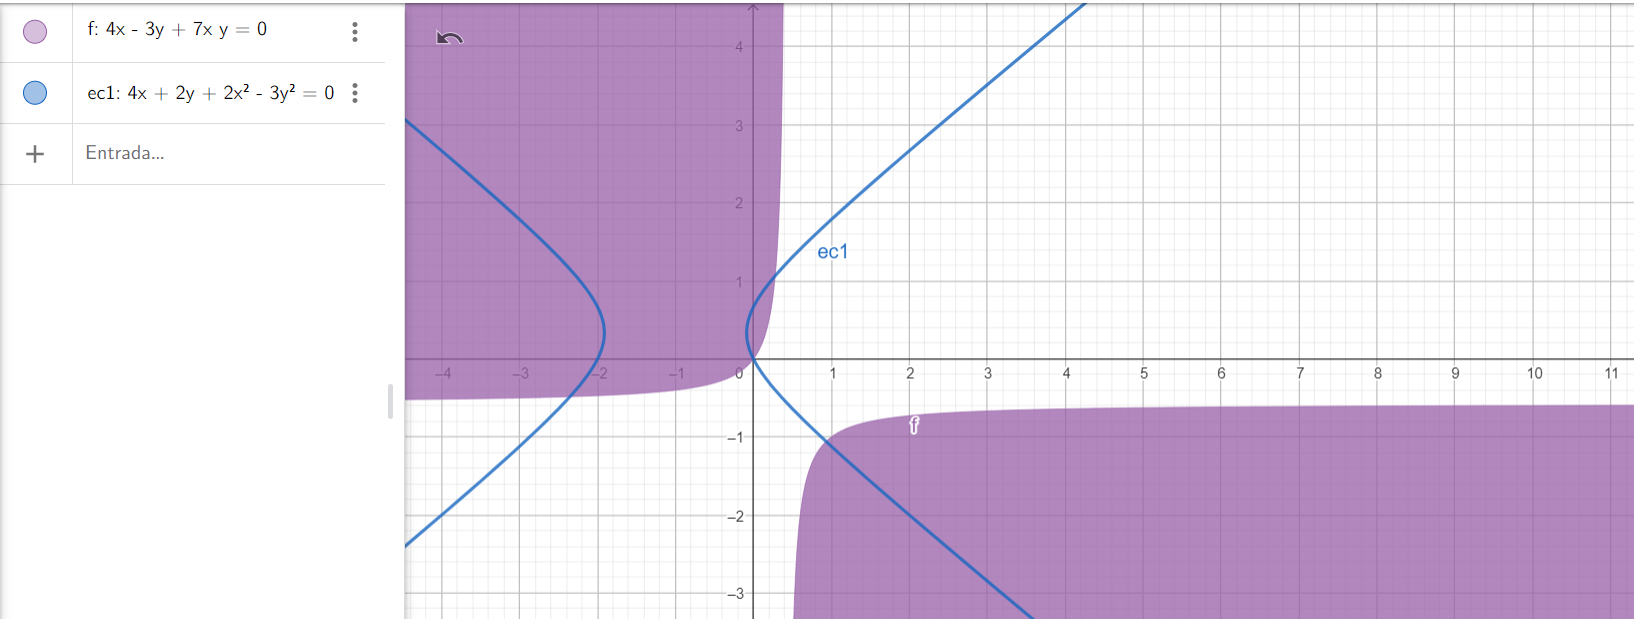

Mas o menos los puntos son (0,0), (0.28, 1.4), (0.8, -1.2), (-2.38, -0.23)

In [359]:
# Define domain bounds
lower_bound = -5
upper_bound = 5
dimension = 2
num_points = 100
#(0,0), (0.28, 1.4), (0.8, -1.2), (-2.38, -0.23)

bounds = [(lower_bound, upper_bound) for _ in range(dimension)]
initial_points = [np.array([0,0]), np.array([0.28, 1.4]), np.array([0.8, -1.2]), np.array([-2.38, -0.23])]
zeros = find_critical_points(F, J, bounds, initial_points)
print(zeros)


[array([0., 0.]), array([0.27888449, 1.06463911]), array([ 0.93250143, -1.05740471]), array([-2.35424307, -0.48342488])]


Zeros encontrados: [array([0., 0.]), array([0.27888449, 1.06463911]), array([ 0.93250143, -1.05740471]), array([-2.35424307, -0.48342488])]


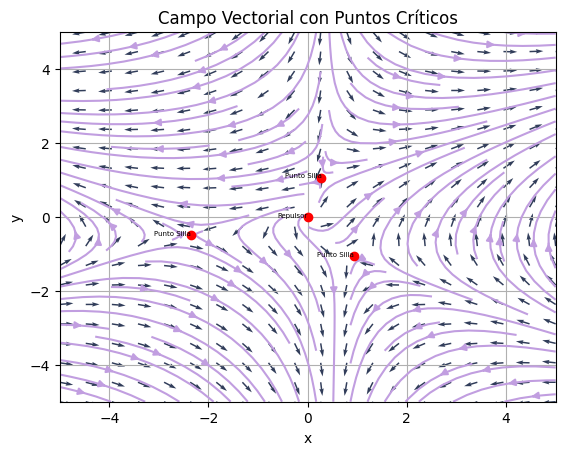

---- 1 ----
Punto crítico: [0. 0.]
Clasificación: Repulsor
Matriz Jacobiana: [[ 4. -3.]
 [ 0.  2.]]

---- 2 ----
Punto crítico: [0.27888449 1.06463911]
Clasificación: Punto Silla
Matriz Jacobiana: [[11.45247378 -1.04780855]
 [ 2.23107594 -4.38783467]]

---- 3 ----
Punto crítico: [ 0.93250143 -1.05740471]
Clasificación: Punto Silla
Matriz Jacobiana: [[-3.40183298  3.52751004]
 [ 7.46001148  8.34442827]]

---- 4 ----
Punto crítico: [-2.35424307 -0.48342488]
Clasificación: Punto Silla
Matriz Jacobiana: [[  0.61602587 -19.47970149]
 [-18.83394456   4.90054926]]



In [360]:
print(f"Zeros encontrados: {zeros}")
plot_field_and_critical_points(F, J, zeros, bounds)
for i, zero in enumerate(zeros):
    print("----", i+1, "----")
    print(f"Punto crítico: {zero}")
    J_matrix = J(zero)
    classification = classify_point(J_matrix)
    print(f"Clasificación: {classification}")
    print(f"Matriz Jacobiana: {J_matrix}")
    print()

## Repetimos con el segundo
$$
\frac{dy}{dx} = \frac{-18 + 6x + 2y - xy}{33 - 10x - 3y + x^2}
$$

Igualamos el numerador y denominador con 0
$$
-18 + 6x + 2y - xy = 0
$$
$$
33 - 10x - 3y + x^2 = 0
$$

In [361]:
def G(x):
    return np.array([
        -18 + 6*x[0] + 2*x[1] - x[0]*x[1],
        33 - 10*x[0] - 3*x[1] + x[0]**2
    ])


Para obtener el Jacobiano de \( F \), necesitamos calcular las derivadas parciales del numerador y del denominador respecto a \( x \) y \( y \). La matriz Jacobiana \( J \) se define como:

$$
J = \begin{bmatrix}
\frac{\partial F}{\partial x} & \frac{\partial F}{\partial y} \\
\frac{\partial F}{\partial x} & \frac{\partial F}{\partial y}
\end{bmatrix}
$$

Donde:

$$
F_1(x, y) = -18 + 6x + 2y - xy
$$
$$
F_2(x, y) = 33 - 10x - 3y + x^2
$$

El Jacobiano para esta función es:

$$
J = \begin{bmatrix}
\frac{\partial}{\partial x} \left( \frac{F_1(x, y)}{F_2(x, y)} \right) & \frac{\partial}{\partial y} \left( \frac{F_1(x, y)}{F_2(x, y)} \right) \\
\frac{\partial}{\partial x} \left( \frac{F_1(x, y)}{F_2(x, y)} \right) & \frac{\partial}{\partial y} \left( \frac{F_1(x, y)}{F_2(x, y)} \right)
\end{bmatrix}
$$

La derivada parcial de \( F \) respecto a \( x \) y \( y \) se calcula usando la regla del cociente:

$$
\frac{\partial}{\partial x} \left( \frac{F_1(x, y)}{F_2(x, y)} \right) = \frac{(F_2(x, y) \cdot \frac{\partial F_1}{\partial x} - F_1(x, y) \cdot \frac{\partial F_2}{\partial x})}{(F_2(x, y))^2}
$$

$$
\frac{\partial}{\partial y} \left( \frac{F_1(x, y)}{F_2(x, y)} \right) = \frac{(F_2(x, y) \cdot \frac{\partial F_1}{\partial y} - F_1(x, y) \cdot \frac{\partial F_2}{\partial y})}{(F_2(x, y))^2}
$$

Donde:

$$
\frac{\partial F_1}{\partial x} = 6 - y
$$
$$
\frac{\partial F_1}{\partial y} = 2 - x
$$
$$
\frac{\partial F_2}{\partial x} = -10 + 2x
$$
$$
\frac{\partial F_2}{\partial y} = -3
$$

In [362]:
def JG(x):
    return np.array([
        [6 - x[1], 2 - x[0]],
        [10 - 2*x[0], -3]
    ])

### Graficamos para ver más o menos que puntos son:
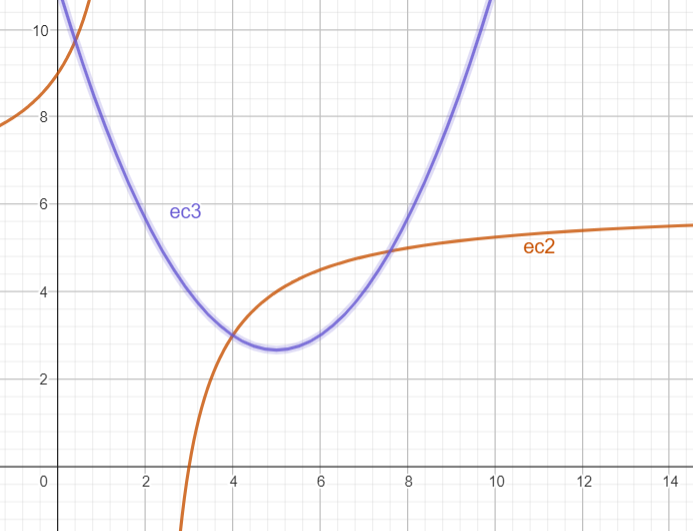

En este caso vamos a probar con (1, 9.6), (4, 3), (7.6, 5)

In [363]:
# Define domain bounds
lower_bound = -13
upper_bound = 13
dimension = 2
num_points = 1000
# (1, 9.6), (4, 3), (7.6, 5)

bounds = [(lower_bound, upper_bound) for _ in range(dimension)]
initial_points = [np.array([0.3234, 9.737]), np.array([4, 3]), np.array([7.60555, 4.929])]
zeros = find_critical_points(G, JG, bounds, initial_points)


Zeros encontrados: [array([0.39444872, 9.73703418]), array([4., 3.]), array([7.60555128, 4.92963248])]


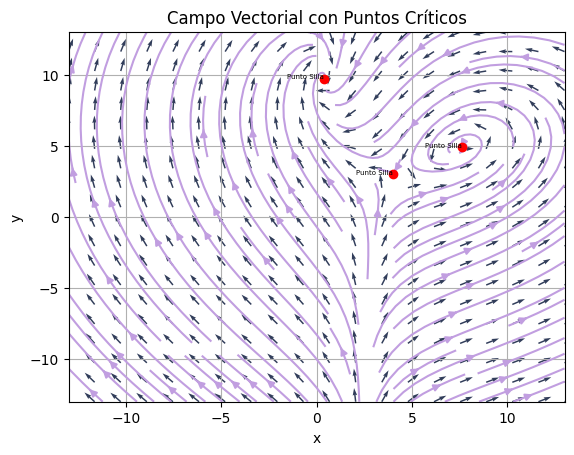

---- 1 ----
Punto crítico: [0.39444872 9.73703418]
Clasificación: Punto Silla
Matriz Jacobiana: [[-3.73703418  1.60555128]
 [ 9.21110255 -3.        ]]

---- 2 ----
Punto crítico: [4. 3.]
Clasificación: Punto Silla
Matriz Jacobiana: [[ 3. -2.]
 [ 2. -3.]]

---- 3 ----
Punto crítico: [7.60555128 4.92963248]
Clasificación: Punto Silla
Matriz Jacobiana: [[ 1.07036752 -5.60555128]
 [-5.21110255 -3.        ]]



In [364]:
print(f"Zeros encontrados: {zeros}")
plot_field_and_critical_points(G, JG, zeros, bounds)
for i, zero in enumerate(zeros):
    print("----", i+1, "----")
    print(f"Punto crítico: {zero}")
    J_matrix = JG(zero)
    classification = classify_point(J_matrix)
    print(f"Clasificación: {classification}")
    print(f"Matriz Jacobiana: {J_matrix}")
    print()